# Introduction

The idea of this project is to see if we can predict with some level of accuracy, the winners of NBA games based on previous games played.

We will be using the dataset from [Kaggle](https://www.kaggle.com/datasets/nathanlauga/nba-games/data) which contains data from 2004 to december of 2020.

The dataset contains the following csv files:
- teams.csv
- games.csv
- game_details.csv
- players.csv
- ranking.csv

In [1308]:
import pandas as pd
import numpy as np

# Load games.csv into a pandas dataframe
GamesDF = pd.read_csv('games.csv')

# Print the first 5 rows of the dataframe
print(GamesDF.head())

  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2022-12-22  22200477            Final    1610612740       1610612759   
1    2022-12-22  22200478            Final    1610612762       1610612764   
2    2022-12-21  22200466            Final    1610612739       1610612749   
3    2022-12-21  22200467            Final    1610612755       1610612765   
4    2022-12-21  22200468            Final    1610612737       1610612741   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  AST_home  \
0    2022    1610612740     126.0        0.484        0.926  ...      25.0   
1    2022    1610612762     120.0        0.488        0.952  ...      16.0   
2    2022    1610612739     114.0        0.482        0.786  ...      22.0   
3    2022    1610612755     113.0        0.441        0.909  ...      27.0   
4    2022    1610612737     108.0        0.429        1.000  ...      22.0   

   REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT_PCT_away  FG3_P

# Data Preprocessing

In [1309]:
# Check data types
print(GamesDF.dtypes)

GAME_DATE_EST        object
GAME_ID               int64
GAME_STATUS_TEXT     object
HOME_TEAM_ID          int64
VISITOR_TEAM_ID       int64
SEASON                int64
TEAM_ID_home          int64
PTS_home            float64
FG_PCT_home         float64
FT_PCT_home         float64
FG3_PCT_home        float64
AST_home            float64
REB_home            float64
TEAM_ID_away          int64
PTS_away            float64
FG_PCT_away         float64
FT_PCT_away         float64
FG3_PCT_away        float64
AST_away            float64
REB_away            float64
HOME_TEAM_WINS        int64
dtype: object


We have some cleaning to do.

In [1310]:
# convert GAME_DATE_EST to datetime
GamesDF['GAME_DATE_EST'] = pd.to_datetime(GamesDF['GAME_DATE_EST'])

# Drop GAME_STATUS_TEXT
GamesDF = GamesDF.drop(columns=['GAME_STATUS_TEXT'])

# Check data types
print(GamesDF.dtypes)

GAME_DATE_EST      datetime64[ns]
GAME_ID                     int64
HOME_TEAM_ID                int64
VISITOR_TEAM_ID             int64
SEASON                      int64
TEAM_ID_home                int64
PTS_home                  float64
FG_PCT_home               float64
FT_PCT_home               float64
FG3_PCT_home              float64
AST_home                  float64
REB_home                  float64
TEAM_ID_away                int64
PTS_away                  float64
FG_PCT_away               float64
FT_PCT_away               float64
FG3_PCT_away              float64
AST_away                  float64
REB_away                  float64
HOME_TEAM_WINS              int64
dtype: object


# Preparation

In order To start working with the data we must first decode the team ID's into thier respective team names

In [1311]:
# Load teams.csv into a pandas dataframe
TeamsDF = pd.read_csv('teams.csv')

# Print the first 5 rows of the dataframe
print(TeamsDF.head())

   LEAGUE_ID     TEAM_ID  MIN_YEAR  MAX_YEAR ABBREVIATION   NICKNAME  \
0          0  1610612737      1949      2019          ATL      Hawks   
1          0  1610612738      1946      2019          BOS    Celtics   
2          0  1610612740      2002      2019          NOP   Pelicans   
3          0  1610612741      1966      2019          CHI      Bulls   
4          0  1610612742      1980      2019          DAL  Mavericks   

   YEARFOUNDED         CITY                     ARENA  ARENACAPACITY  \
0         1949      Atlanta          State Farm Arena        18729.0   
1         1946       Boston                 TD Garden        18624.0   
2         2002  New Orleans      Smoothie King Center            NaN   
3         1966      Chicago             United Center        21711.0   
4         1980       Dallas  American Airlines Center        19200.0   

             OWNER  GENERALMANAGER      HEADCOACH DLEAGUEAFFILIATION  
0     Tony Ressler  Travis Schlenk   Lloyd Pierce      Erie Bay

Now that we have the TEAD_ID and their corresponding team abbreaivations we can start working with the data.

In [1312]:
# Make a dictionary of team names and team IDs
TeamNameDict = dict(zip(TeamsDF['TEAM_ID'], TeamsDF['ABBREVIATION']))

# Print the first 5 rows of the dataframe
print(GamesDF.head())

  GAME_DATE_EST   GAME_ID  HOME_TEAM_ID  VISITOR_TEAM_ID  SEASON  \
0    2022-12-22  22200477    1610612740       1610612759    2022   
1    2022-12-22  22200478    1610612762       1610612764    2022   
2    2022-12-21  22200466    1610612739       1610612749    2022   
3    2022-12-21  22200467    1610612755       1610612765    2022   
4    2022-12-21  22200468    1610612737       1610612741    2022   

   TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  FG3_PCT_home  AST_home  \
0    1610612740     126.0        0.484        0.926         0.382      25.0   
1    1610612762     120.0        0.488        0.952         0.457      16.0   
2    1610612739     114.0        0.482        0.786         0.313      22.0   
3    1610612755     113.0        0.441        0.909         0.297      27.0   
4    1610612737     108.0        0.429        1.000         0.378      22.0   

   REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  \
0      46.0    1610612759     117.0  

Next we will need to calculate the winning margin for each game. This will be done by subtracting the losing team's score from the winning team's score.

In [1313]:

# Calculate the winning margin
GamesDF['WINNING_MARGIN'] = np.where(GamesDF['PTS_home'] > GamesDF['PTS_away'], GamesDF['PTS_home'] - GamesDF['PTS_away'], GamesDF['PTS_away'] - GamesDF['PTS_home'])

We must take into account seasons. There is a season column and we will group by season

In [1314]:
season_team_grouped_data = GamesDF.groupby(['SEASON', 'TEAM_ID_home'])

# print the keys
print(season_team_grouped_data.groups.keys())


dict_keys([(2003, 1610612737), (2003, 1610612738), (2003, 1610612739), (2003, 1610612740), (2003, 1610612741), (2003, 1610612742), (2003, 1610612743), (2003, 1610612744), (2003, 1610612745), (2003, 1610612746), (2003, 1610612747), (2003, 1610612748), (2003, 1610612749), (2003, 1610612750), (2003, 1610612751), (2003, 1610612752), (2003, 1610612753), (2003, 1610612754), (2003, 1610612755), (2003, 1610612756), (2003, 1610612757), (2003, 1610612758), (2003, 1610612759), (2003, 1610612760), (2003, 1610612761), (2003, 1610612762), (2003, 1610612763), (2003, 1610612764), (2003, 1610612765), (2004, 1610612737), (2004, 1610612738), (2004, 1610612739), (2004, 1610612740), (2004, 1610612741), (2004, 1610612742), (2004, 1610612743), (2004, 1610612744), (2004, 1610612745), (2004, 1610612746), (2004, 1610612747), (2004, 1610612748), (2004, 1610612749), (2004, 1610612750), (2004, 1610612751), (2004, 1610612752), (2004, 1610612753), (2004, 1610612754), (2004, 1610612755), (2004, 1610612756), (2004, 16

Now let's split the data into training and testing sets. We will use the 2019-2020 season as our testing set and the rest of the data as our training set.

In [1315]:
# Now that we have the data grouped by season and by team we can split the data into training and testing sets
# We will use 5 season increments for the training data and 1 season increments for the testing data

# Create a list of seasons
seasons = GamesDF['SEASON'].unique()
seasons.sort()

# Create a list of seasons to use for training access the most recent 5 seasons minus the last season
train_seasons = seasons[-6:-1]

# Create a list of seasons to use for testing
test_seasons = seasons[-1:]

print("Training Data Shape:", train_seasons.shape)
print("Testing Data Shape:", test_seasons.shape)

print("Training Seasons:", train_seasons)
print("Testing Seasons:", test_seasons)



Training Data Shape: (5,)
Testing Data Shape: (1,)
Training Seasons: [2017 2018 2019 2020 2021]
Testing Seasons: [2022]


Now that we have test and training data lets perform a exploratory data analysis on the training data.

# Exploratory Data Analysis

# Introduction

The idea of this project is to see if we can predict with some level of accuracy, the winners of NBA games based on previous games played.

We will be using the dataset from [Kaggle](https://www.kaggle.com/datasets/nathanlauga/nba-games/data) which contains data from 2004 to december of 2020.

The dataset contains the following csv files:
- teams.csv
- games.csv
- game_details.csv
- players.csv
- ranking.csv

In [1316]:
import pandas as pd
import numpy as np

# Load games.csv into a pandas dataframe
GamesDF = pd.read_csv('games.csv')

# Print the first 5 rows of the dataframe
print(GamesDF.head())

  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2022-12-22  22200477            Final    1610612740       1610612759   
1    2022-12-22  22200478            Final    1610612762       1610612764   
2    2022-12-21  22200466            Final    1610612739       1610612749   
3    2022-12-21  22200467            Final    1610612755       1610612765   
4    2022-12-21  22200468            Final    1610612737       1610612741   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  AST_home  \
0    2022    1610612740     126.0        0.484        0.926  ...      25.0   
1    2022    1610612762     120.0        0.488        0.952  ...      16.0   
2    2022    1610612739     114.0        0.482        0.786  ...      22.0   
3    2022    1610612755     113.0        0.441        0.909  ...      27.0   
4    2022    1610612737     108.0        0.429        1.000  ...      22.0   

   REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT_PCT_away  FG3_P

# Preparation

In order To start working with the data we must first decode the team ID's into thier respective team names

In [1317]:
# Load teams.csv into a pandas dataframe
TeamsDF = pd.read_csv('teams.csv')

# Print the first 5 rows of the dataframe
print(TeamsDF.head())

   LEAGUE_ID     TEAM_ID  MIN_YEAR  MAX_YEAR ABBREVIATION   NICKNAME  \
0          0  1610612737      1949      2019          ATL      Hawks   
1          0  1610612738      1946      2019          BOS    Celtics   
2          0  1610612740      2002      2019          NOP   Pelicans   
3          0  1610612741      1966      2019          CHI      Bulls   
4          0  1610612742      1980      2019          DAL  Mavericks   

   YEARFOUNDED         CITY                     ARENA  ARENACAPACITY  \
0         1949      Atlanta          State Farm Arena        18729.0   
1         1946       Boston                 TD Garden        18624.0   
2         2002  New Orleans      Smoothie King Center            NaN   
3         1966      Chicago             United Center        21711.0   
4         1980       Dallas  American Airlines Center        19200.0   

             OWNER  GENERALMANAGER      HEADCOACH DLEAGUEAFFILIATION  
0     Tony Ressler  Travis Schlenk   Lloyd Pierce      Erie Bay

Now that we have the TEAD_ID and their corresponding team abbreaivations we can start working with the data.

In [1318]:
# Make a dictionary of team names and team IDs
TeamNameDict = dict(zip(TeamsDF['TEAM_ID'], TeamsDF['ABBREVIATION']))
GamesDF['TEAM_NAME_HOME'] = GamesDF['TEAM_ID_home'].map(TeamNameDict)
GamesDF['TEAM_NAME_AWAY'] = GamesDF['TEAM_ID_away'].map(TeamNameDict)

# Print the first 5 rows of the dataframe
print(GamesDF.head())

  GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0    2022-12-22  22200477            Final    1610612740       1610612759   
1    2022-12-22  22200478            Final    1610612762       1610612764   
2    2022-12-21  22200466            Final    1610612739       1610612749   
3    2022-12-21  22200467            Final    1610612755       1610612765   
4    2022-12-21  22200468            Final    1610612737       1610612741   

   SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  \
0    2022    1610612740     126.0        0.484        0.926  ...   
1    2022    1610612762     120.0        0.488        0.952  ...   
2    2022    1610612739     114.0        0.482        0.786  ...   
3    2022    1610612755     113.0        0.441        0.909  ...   
4    2022    1610612737     108.0        0.429        1.000  ...   

   TEAM_ID_away  PTS_away  FG_PCT_away  FT_PCT_away  FG3_PCT_away  AST_away  \
0    1610612759     117.0        0.478        0.8

Next we will need to calculate the winning margin for each game. This will be done by subtracting the losing team's score from the winning team's score.

In [1319]:

# Calculate the winning margin
GamesDF['WINNING_MARGIN'] = np.where(GamesDF['PTS_home'] > GamesDF['PTS_away'], GamesDF['PTS_home'] - GamesDF['PTS_away'], GamesDF['PTS_away'] - GamesDF['PTS_home'])

We must take into account seasons. There is a season column and we will group by season

In [1320]:
# Get the number of games played in each season
GamesPerSeason = GamesDF.groupby('SEASON')['GAME_ID'].count()
print(GamesPerSeason)

season_team_grouped_data = GamesDF.groupby(['SEASON', 'TEAM_ID_home'])

# print the keys
print(season_team_grouped_data.groups.keys())

SEASON
2003    1385
2004    1362
2005    1432
2006    1419
2007    1411
2008    1425
2009    1424
2010    1422
2011    1104
2012    1420
2013    1427
2014    1418
2015    1416
2016    1405
2017    1382
2018    1378
2019    1241
2020    1249
2021    1389
2022     542
Name: GAME_ID, dtype: int64
dict_keys([(2003, 1610612737), (2003, 1610612738), (2003, 1610612739), (2003, 1610612740), (2003, 1610612741), (2003, 1610612742), (2003, 1610612743), (2003, 1610612744), (2003, 1610612745), (2003, 1610612746), (2003, 1610612747), (2003, 1610612748), (2003, 1610612749), (2003, 1610612750), (2003, 1610612751), (2003, 1610612752), (2003, 1610612753), (2003, 1610612754), (2003, 1610612755), (2003, 1610612756), (2003, 1610612757), (2003, 1610612758), (2003, 1610612759), (2003, 1610612760), (2003, 1610612761), (2003, 1610612762), (2003, 1610612763), (2003, 1610612764), (2003, 1610612765), (2004, 1610612737), (2004, 1610612738), (2004, 1610612739), (2004, 1610612740), (2004, 1610612741), (2004, 1610612

Now let's compute the average winning margin for each team for each season. This will be done by grouping by season and team and then taking the mean of the winning margin.

In [1321]:
# Now that we have the data grouped by season and by team we can split the data into training and testing sets
average_margin_per_team_season = GamesDF.groupby(['SEASON', 'TEAM_NAME_HOME'])[
    'WINNING_MARGIN'].mean().reset_index()

Now let's split the data into training and testing sets. We will use the 2019-2020 season as our testing set and the rest of the data as our training set.

In [1322]:
# Now that we have the data grouped by season and by team we can split the data into training and testing sets
# We will use 5 season increments for the training data and 1 season increments for the testing data

# Create a list of seasons
seasons = GamesDF['SEASON'].unique()
seasons.sort()

# Create a list of seasons to use for training access the most recent 5 seasons minus the last season
train_seasons = list(seasons[-6:-1])
train_df = GamesDF[GamesDF['SEASON'].isin(train_seasons)]

# Create a list of seasons to use for testing
test_seasons = list(seasons[-1:])

print("Training Data Shape:", len(train_seasons))
print("Testing Data Shape:", len(test_seasons))

print("Training Seasons:", train_seasons)
print("Testing Seasons:", test_seasons)

Training Data Shape: 5
Testing Data Shape: 1
Training Seasons: [2017, 2018, 2019, 2020, 2021]
Testing Seasons: [2022]


In [1323]:
import matplotlib.pyplot as plt
import seaborn as sns

## Winning Margin
Let's plot each team's average winning margin for each season.

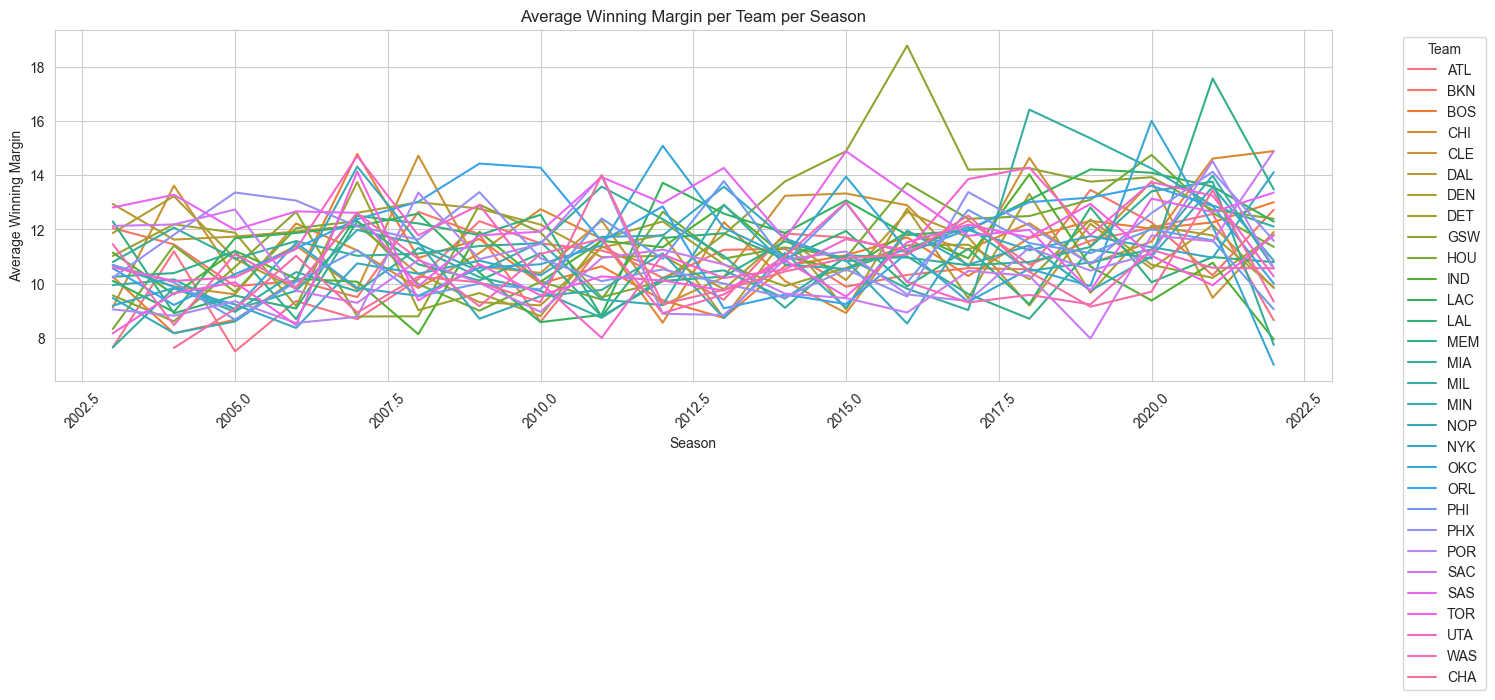

In [1324]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=average_margin_per_team_season, x='SEASON', y='WINNING_MARGIN', hue='TEAM_NAME_HOME')
plt.title('Average Winning Margin per Team per Season')
plt.ylabel('Average Winning Margin')
plt.xlabel('Season')
plt.xticks(rotation=45)
plt.legend(title='Team', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

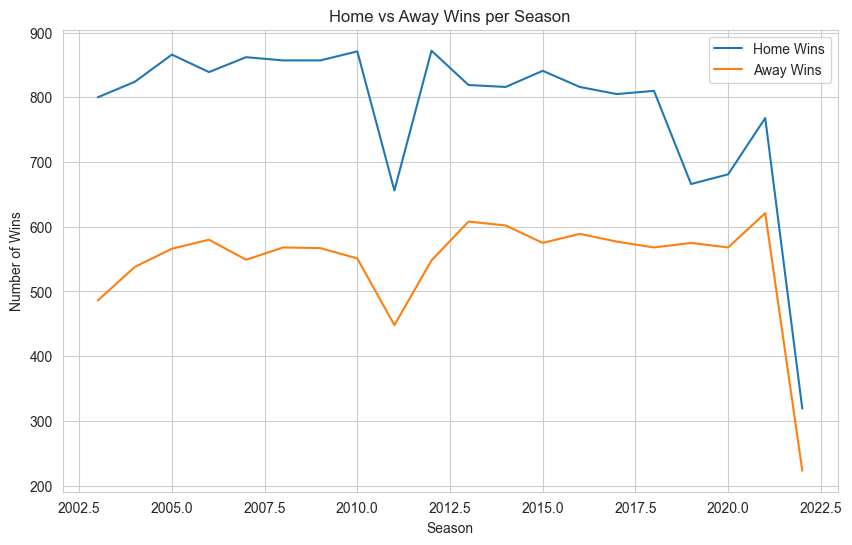

In [1325]:
# Home vs. Away Performance Analysis
home_wins = GamesDF[GamesDF['PTS_home'] >
                    GamesDF['PTS_away']].groupby('SEASON').size()
away_wins = GamesDF[GamesDF['PTS_home'] <
                    GamesDF['PTS_away']].groupby('SEASON').size()

plt.figure(figsize=(10, 6))
plt.plot(home_wins.index, home_wins.values, label='Home Wins')
plt.plot(away_wins.index, away_wins.values, label='Away Wins')
plt.title('Home vs Away Wins per Season')
plt.xlabel('Season')
plt.ylabel('Number of Wins')
plt.legend()
plt.show()

In [1326]:
# Initialize a dictionary to store team strengths
team_strengths = {team_id: 0 for team_id in GamesDF['TEAM_ID_home'].unique()}

# Function to update team strengths
def update_team_strengths(row):
    home_team_id, away_team_id = row['TEAM_ID_home'], row['TEAM_ID_away']
    home_score, away_score = row['PTS_home'], row['PTS_away']

    # Update strengths based on game outcome
    if home_score > away_score:  # Home team wins
        team_strengths[home_team_id] += 1
        team_strengths[away_team_id] -= 1
    elif away_score > home_score:  # Away team wins
        team_strengths[away_team_id] += 1
        team_strengths[home_team_id] -= 1

# Mapping team strength scores to each game
GamesDF['HOME_TEAM_STRENGTH'] = GamesDF['TEAM_ID_home'].map(team_strengths)
GamesDF['AWAY_TEAM_STRENGTH'] = GamesDF['TEAM_ID_away'].map(team_strengths)

# Creating a dictionary to hold season-wise dataframes
season_data = {}
for season in GamesDF['SEASON'].unique():
    season_games = GamesDF[GamesDF['SEASON'] == season]
    # Add any additional preprocessing steps for each season's data here
    season_data[season] = season_games

Now let's Mdoel the data

In [1327]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

models = {}

# Sort the unique seasons in chronological order
unique_seasons = sorted(GamesDF['SEASON'].unique())

for season in unique_seasons:
    # Creating a copy of the slice for the current season
    season_games = GamesDF[GamesDF['SEASON'] == season].copy()

    # Define target variable (1 if home team wins, 0 otherwise)
    season_games['HOME_TEAM_WIN'] = (season_games['PTS_home'] > season_games['PTS_away']).astype(int)

    # Define features and target
    X = season_games[['HOME_TEAM_STRENGTH', 'AWAY_TEAM_STRENGTH']]
    y = season_games['HOME_TEAM_WIN']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and train the model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Test the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Store the model, its accuracy, and confusion matrix
    models[season] = (model, accuracy, cm)

# Display the accuracy and confusion matrix for each season
for season, (model, accuracy, cm) in models.items():
    print(f"Season {season}:")
    print(f"Model Accuracy = {accuracy:.2f}")
    print("Confusion Matrix:")
    print(cm)
    print()


Season 2003:
Model Accuracy = 0.57
Confusion Matrix:
[[  0 119]
 [  0 158]]

Season 2004:
Model Accuracy = 0.64
Confusion Matrix:
[[  0  99]
 [  0 174]]

Season 2005:
Model Accuracy = 0.60
Confusion Matrix:
[[  0 114]
 [  0 173]]

Season 2006:
Model Accuracy = 0.56
Confusion Matrix:
[[  0 124]
 [  0 160]]

Season 2007:
Model Accuracy = 0.60
Confusion Matrix:
[[  0 113]
 [  0 170]]

Season 2008:
Model Accuracy = 0.61
Confusion Matrix:
[[  0 112]
 [  0 173]]

Season 2009:
Model Accuracy = 0.60
Confusion Matrix:
[[  0 114]
 [  0 171]]

Season 2010:
Model Accuracy = 0.62
Confusion Matrix:
[[  0 107]
 [  0 178]]

Season 2011:
Model Accuracy = 0.62
Confusion Matrix:
[[  0  84]
 [  0 137]]

Season 2012:
Model Accuracy = 0.64
Confusion Matrix:
[[  0 103]
 [  0 181]]

Season 2013:
Model Accuracy = 0.55
Confusion Matrix:
[[  0 130]
 [  0 156]]

Season 2014:
Model Accuracy = 0.57
Confusion Matrix:
[[  0 121]
 [  0 163]]

Season 2015:
Model Accuracy = 0.60
Confusion Matrix:
[[  0 115]
 [  0 169]]


Somethings not quite right as we're only getting one half of the confusion matrix. Let's try to fix this.

In [1328]:
def calculate_dynamic_strengths(df):
    team_strengths = {team: 0 for team in df['TEAM_ID_home'].unique()}
    for index, row in df.iterrows():
        home_team, away_team = row['TEAM_ID_home'], row['TEAM_ID_away']
        home_score, away_score = row['PTS_home'], row['PTS_away']

        # Update strengths based on game outcome
        if home_score > away_score:
            team_strengths[home_team] += 1
            team_strengths[away_team] -= 1
        elif away_score > home_score:
            team_strengths[away_team] += 1
            team_strengths[home_team] -= 1

        df.at[index, 'HOME_TEAM_STRENGTH'] = team_strengths[home_team]
        df.at[index, 'AWAY_TEAM_STRENGTH'] = team_strengths[away_team]
    return df

# Apply dynamic strength calculation to training data
train_df = calculate_dynamic_strengths(train_df)


/var/folders/gf/tlzfzjs10vd6dq4cjvsb4js00000gn/T/ipykernel_7589/717627540.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, 'HOME_TEAM_STRENGTH'] = team_strengths[home_team]
/var/folders/gf/tlzfzjs10vd6dq4cjvsb4js00000gn/T/ipykernel_7589/717627540.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, 'AWAY_TEAM_STRENGTH'] = team_strengths[away_team]


In [1329]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

results = {}
time_series_cv = TimeSeriesSplit(n_splits=5)

# Sort the unique seasons in chronological order
unique_seasons = sorted(train_df['SEASON'].unique())

# Prepare the full dataset (across all seasons)
train_df['HOME_TEAM_WIN'] = (
    train_df['PTS_home'] > train_df['PTS_away']).astype(int)
X_full = train_df[['HOME_TEAM_STRENGTH', 'AWAY_TEAM_STRENGTH']]
y_full = train_df['HOME_TEAM_WIN']

for train_index, test_index in time_series_cv.split(X_full):
    X_train, X_test = X_full.iloc[train_index], X_full.iloc[test_index]
    y_train, y_test = y_full.iloc[train_index], y_full.iloc[test_index]

    # Create and train the logistic regression model
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Test the model
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Cross-validation within each temporal split
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)

    # Store the results for the current temporal split
    results[f'Split_{len(results)+1}'] = {
        'model': model,
        'accuracy': accuracy,
        'confusion_matrix': cm,
        'cross_validation_scores': cv_scores
    }

# Display the accuracy and confusion matrix for each temporal split
for split, result in results.items():
    print(f"{split}:")
    print(f"Model Accuracy = {result['accuracy']:.2f}")
    print("Confusion Matrix:")
    print(result['confusion_matrix'])
    print(f"Cross-Validation Scores: {result['cross_validation_scores']}")
    print()

# Print the average accuracy across all temporal splits
average_accuracy = np.mean([result['accuracy'] for result in results.values()])
print(f"Average Accuracy = {average_accuracy:.2f}")

/var/folders/gf/tlzfzjs10vd6dq4cjvsb4js00000gn/T/ipykernel_7589/2029281396.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['HOME_TEAM_WIN'] = (


Split_1:
Model Accuracy = 0.64
Confusion Matrix:
[[306 184]
 [212 404]]
Cross-Validation Scores: [0.62162162 0.72972973 0.72972973 0.61711712 0.64253394]

Split_2:
Model Accuracy = 0.56
Confusion Matrix:
[[248 272]
 [215 371]]
Cross-Validation Scores: [0.60045147 0.68171558 0.61173815 0.64108352 0.66365688]

Split_3:
Model Accuracy = 0.58
Confusion Matrix:
[[226 257]
 [211 412]]
Cross-Validation Scores: [0.58195489 0.6310241  0.64909639 0.59036145 0.56024096]

Split_4:
Model Accuracy = 0.60
Confusion Matrix:
[[210 232]
 [213 451]]
Cross-Validation Scores: [0.58013544 0.61963883 0.60677966 0.5740113  0.57853107]

Split_5:
Model Accuracy = 0.58
Confusion Matrix:
[[208 263]
 [197 438]]
Cross-Validation Scores: [0.57181572 0.61607949 0.5799458  0.58137432 0.58679928]

Average Accuracy = 0.59


Next we will try to train the model only using the prior seasons data then itertiavely add the next season's data to see if we can improve the model's accuracy.

In [1332]:
# Function to update team strengths dynamically
def update_dynamic_strengths(df, team_strengths):
    for index, row in df.iterrows():
        home_team, away_team = row['TEAM_ID_home'], row['TEAM_ID_away']
        home_score, away_score = row['PTS_home'], row['PTS_away']

        if home_score > away_score:
            team_strengths[home_team] += 1
            team_strengths[away_team] -= 1
        elif away_score > home_score:
            team_strengths[away_team] += 1
            team_strengths[home_team] -= 1

        df.at[index, 'HOME_TEAM_STRENGTH'] = team_strengths[home_team]
        df.at[index, 'AWAY_TEAM_STRENGTH'] = team_strengths[away_team]

    return df, team_strengths

In [1331]:
# Initialize team strengths
initial_team_strengths = {team: 0 for team in GamesDF['TEAM_ID_home'].unique()}

# Split dataset into prior season and current season
prior_season = max(GamesDF['SEASON']) - 1
current_season = max(GamesDF['SEASON'])

prior_season_df = GamesDF[GamesDF['SEASON'] == prior_season]
current_season_df = GamesDF[GamesDF['SEASON'] == current_season]

# Prepare the target variable
prior_season_df['HOME_TEAM_WIN'] = (prior_season_df['PTS_home'] > prior_season_df['PTS_away']).astype(int)

# Train initial model on prior season
X_prior = prior_season_df[['HOME_TEAM_STRENGTH', 'AWAY_TEAM_STRENGTH']]
y_prior = prior_season_df['HOME_TEAM_WIN']

model = LogisticRegression()
model.fit(X_prior, y_prior)

# Initialize results tracking
accuracy_progress = []

# Update the model after each game in the current season
for index, row in current_season_df.iterrows():
    # Update team strengths
    single_game_df = current_season_df.loc[[index]]
    single_game_df, initial_team_strengths = update_dynamic_strengths(single_game_df, initial_team_strengths)

    # Test the model with the current game
    X_test = single_game_df[['HOME_TEAM_STRENGTH', 'AWAY_TEAM_STRENGTH']]
    y_test = single_game_df['HOME_TEAM_WIN']

    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracy_progress.append(accuracy)

    # Retrain the model with updated data
    updated_df = pd.concat([prior_season_df, current_season_df.loc[:index]])
    X_updated = updated_df[['HOME_TEAM_STRENGTH', 'AWAY_TEAM_STRENGTH']]
    y_updated = updated_df['HOME_TEAM_WIN']

    model.fit(X_updated, y_updated)

# Display the accuracy progression
print("Accuracy Progression:")
for i, acc in enumerate(accuracy_progress):
    print(f"Game {i+1}: {acc:.2f}")

# Calculate and display average accuracy over the season
average_accuracy = sum(accuracy_progress) / len(accuracy_progress)
print(f"Average Accuracy: {average_accuracy:.2f}")

/var/folders/gf/tlzfzjs10vd6dq4cjvsb4js00000gn/T/ipykernel_7589/1040313489.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prior_season_df['HOME_TEAM_WIN'] = (prior_season_df['PTS_home'] > prior_season_df['PTS_away']).astype(int)


KeyError: 'HOME_TEAM_WIN'